# Insurance premium prediction

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_column',None)

In [93]:
df=pd.read_csv(r'insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [95]:
df.shape

(1338, 7)

## Exploratory Data Analysis

In [96]:
df.describe(percentiles=(0.01,0.1,0.25,0.5,0.75,0.9,0.99)).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
age,1338.0,39.207025,14.049960,18.00,18.0000,19.000,27.0000,39.00,51.000,59.000,64.0000,64.00
bmi,1338.0,30.665471,6.098382,16.00,17.9370,23.000,26.3000,30.40,34.700,38.630,46.3890,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,0.000,0.0000,1.00,2.000,3.000,5.0000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,1252.9761,2346.535,4740.2875,9382.03,16639.915,34831.716,48537.4806,63770.43


### Seperating Numerical and Categorical features

In [97]:
num=df.select_dtypes('number')
char=df.select_dtypes('object')

### Distribution plots of numerical features

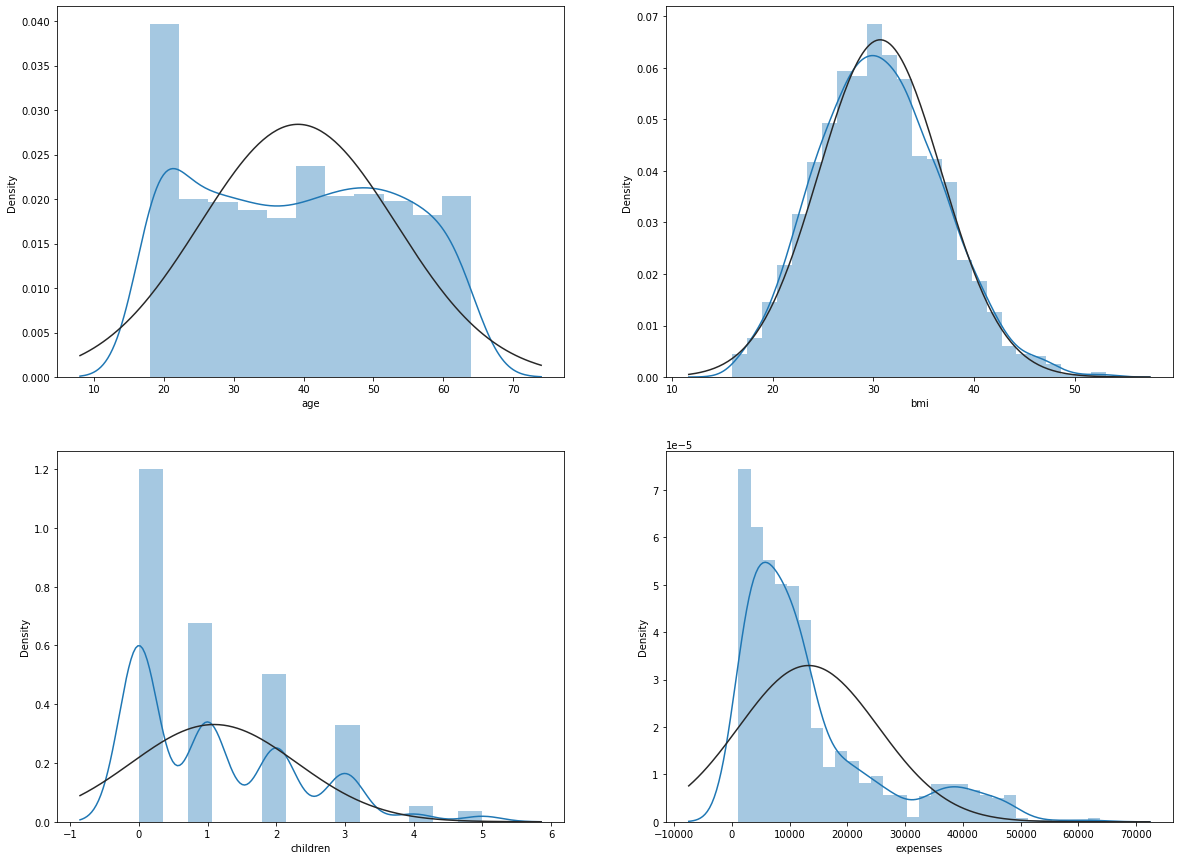

In [98]:
from scipy.stats import norm
plt.figure(figsize=(20,15))
for i,var in enumerate(num.columns):
    plt.subplot(2,2,i+1)
    sns.distplot(num[var],fit=norm)

### Boxplot of numerical features

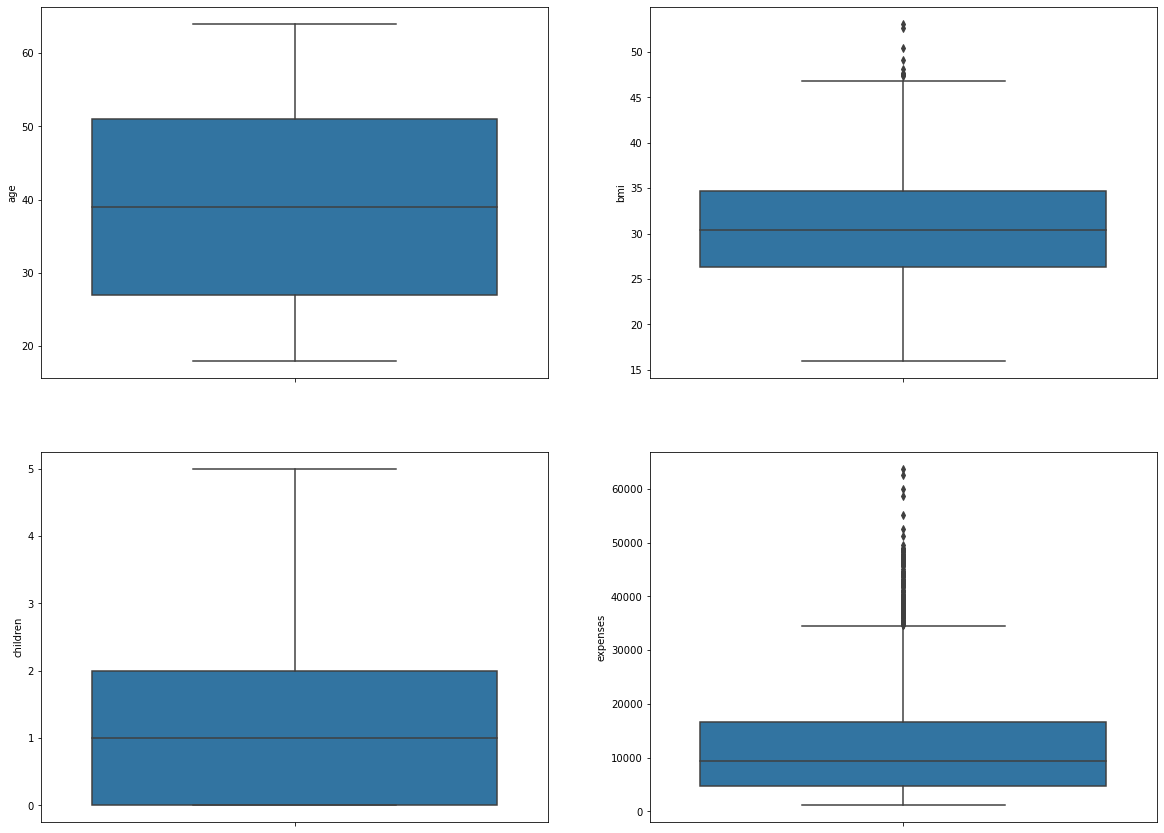

In [99]:
plt.figure(figsize=(20,15))
for i,var in enumerate(num.columns):
    plt.subplot(2,2,i+1)
    sns.boxplot(y=num[var])

### Outlier treatment

Dropping observations which have expenses more than 99 percentile

In [100]:
df=df[num['expenses'] < np.percentile(num['expenses'],99)]
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


### Pairplot between numerical features

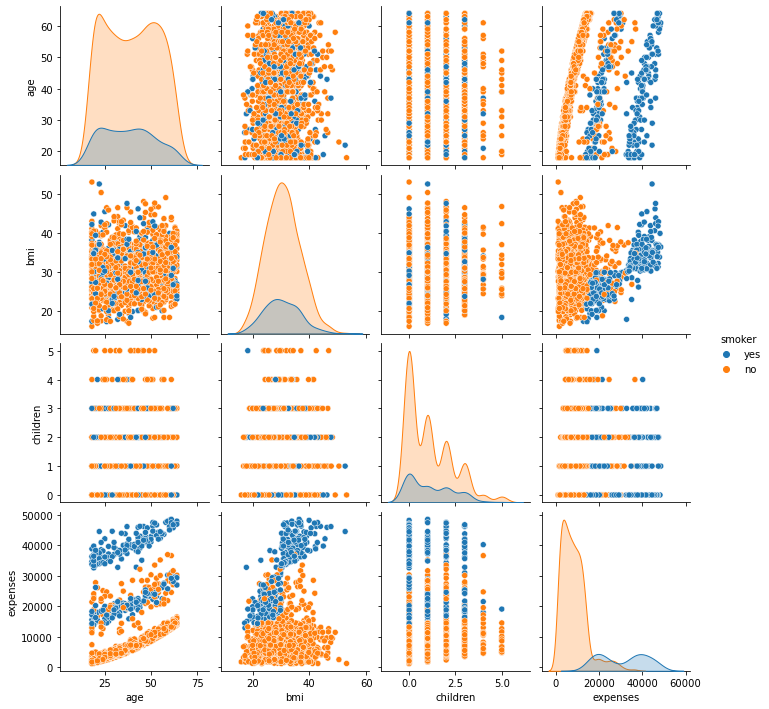

In [101]:
sns.pairplot(df,hue='smoker')

### Checking missing values

In [102]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

### Checking duplicate values

In [103]:
df.duplicated().sum()

1

In [104]:
df.shape

(1324, 7)

### Dropping duplicate observations

In [105]:
df=df.drop_duplicates()

In [106]:
df.shape

(1323, 7)

In [107]:
num=df.select_dtypes('number')
char=df.select_dtypes('object')

### Finding unique values of numerical features

In [108]:
def unique_value(x):
    x=x.value_counts().count()
    return(x)
num_count=pd.DataFrame(num.apply(lambda x: unique_value(x)),columns=['Value_counts'])
num_count.head()

,Value_counts
age,47
bmi,274
children,6
expenses,1323


### Seperating numerical features which have value counts less than 20 

In [109]:
cat=num[num_count[num_count['Value_counts']<20].index]
cat.head()

,children
0,0
1,1
2,3
3,0
4,0


In [110]:
num=num.drop(['children'],axis=1)

### Heatmap of correlation of numerical features

<AxesSubplot:>

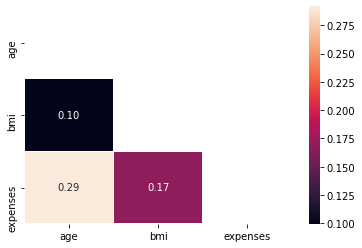

In [111]:
sns.heatmap(num.corr(),linewidths=0.3,annot=True,fmt='0.2F',mask=np.triu(num.corr()))

### Concating all categorical features

In [112]:
char=pd.concat([char,cat],axis=1,join='inner')
char.head()

,sex,smoker,region,children
0,female,yes,southwest,0
1,male,no,southeast,1
2,male,no,southeast,3
3,male,no,northwest,0
4,male,no,northwest,0


### Pie chart of categorical feature value counts percentages

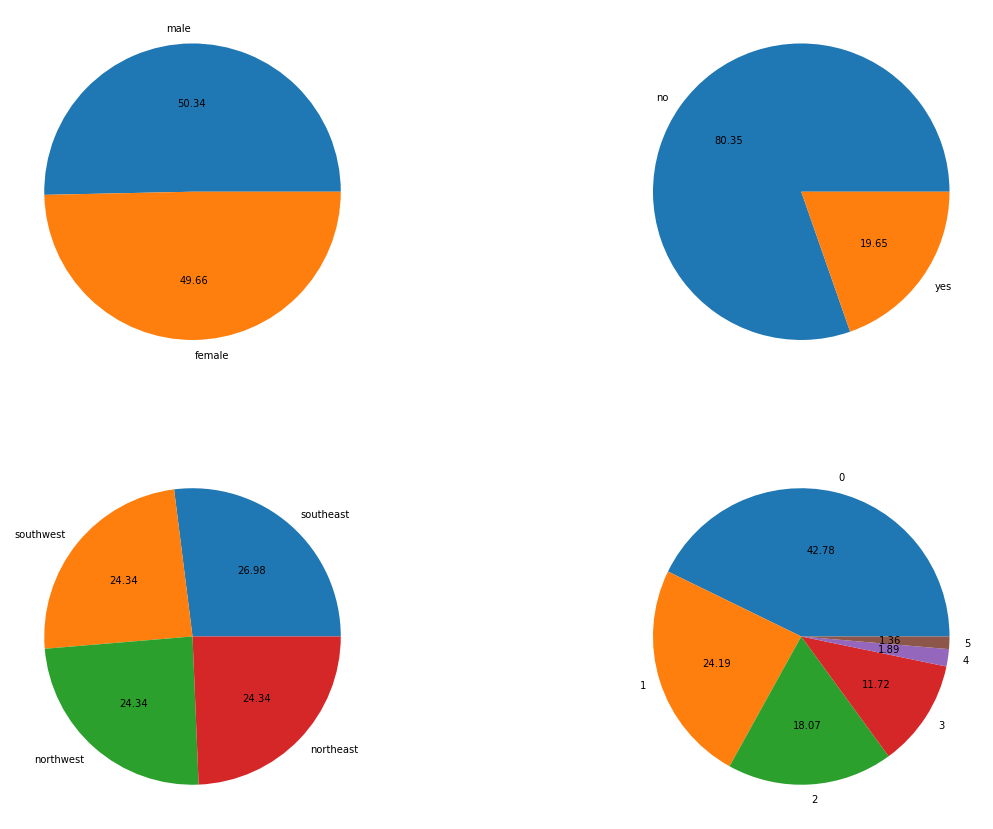

In [113]:
plt.figure(figsize=(20,15))
for i,var in enumerate(char.columns):
    plt.subplot(2,2,i+1)
    plt.pie(char[var].value_counts(),labels=char[var].value_counts().keys(),autopct='%0.2F')

### Dependent variable definition

In [114]:
y=num['expenses']
df_char=pd.concat([char,y],axis=1)

In [115]:
y.mean()

12855.747021919879

### Bi-Variate analysis of categorical features

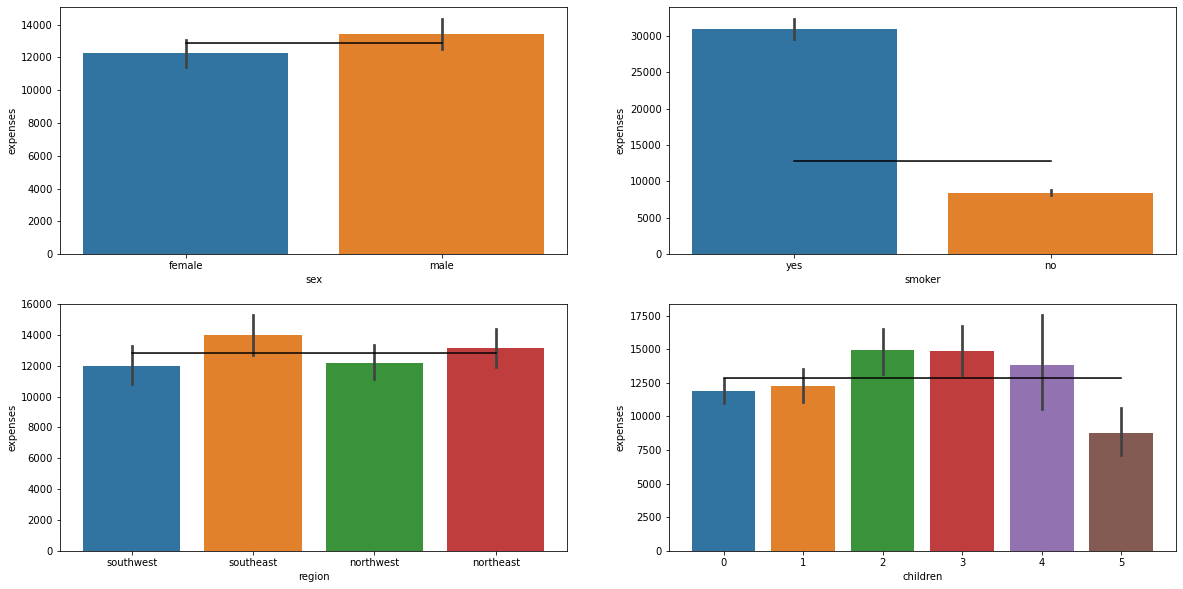

In [116]:
plt.figure(figsize=(20,10))
for i,var in enumerate(char.columns):
    plt.subplot(2,2,i+1)
    sns.barplot(data=df_char,x=var,y='expenses')
    sns.lineplot(x=char[var],y=y.mean(),color='black')

- smoker and children values varies with respect to mean of dependent variable.   
- slope of these two variable is good which have more impact in predictions.   
- sex and region values are around the mean, there is no much deviation from the mean which doesn't have much influence in predictions

## Data Processing 

### Onehot encoding 

In [117]:
char1=pd.get_dummies(char,drop_first=True)
char1.head()

,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,0,1,0,0,1
1,1,1,0,0,1,0
2,3,1,0,0,1,0
3,0,1,0,1,0,0
4,0,1,0,1,0,0


In [118]:
num.drop(['expenses'],axis=1,inplace=True)

### Scaling numerical features.

In [119]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
num=pd.DataFrame(scaler.fit_transform(num),index=num.index,columns=num.columns)
num.head()

,age,bmi
0,-1.434549,-0.442877
1,-1.505901,0.529409
2,-0.792375,0.397574
3,-0.435612,-1.299807
4,-0.506965,-0.278082


### Concating all independent variables

In [120]:
X=pd.concat([num,char1],axis=1)
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.434549,-0.442877,0,0,1,0,0,1
1,-1.505901,0.529409,1,1,0,0,1,0
2,-0.792375,0.397574,3,1,0,0,1,0
3,-0.435612,-1.299807,0,1,0,1,0,0
4,-0.506965,-0.278082,0,1,0,1,0,0


### Splitting data into train and test

In [121]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [122]:
print(y_train.mean())
print(y_test.mean())

12839.966001890365
12918.752000000002


## Model Building 

### Statsmodel - LinearRegression

In [123]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_train)
X_test_sm=sm.add_constant(X_test)
model=sm.OLS(y_train,X_train_sm)
reg=model.fit()

### Summary

In [124]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               expenses   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     406.8
Date:                Sat, 09 Oct 2021   Prob (F-statistic):          3.12e-315
Time:                        10:40:18   Log-Likelihood:                -10627.
No. Observations:                1058   AIC:                         2.127e+04
Df Residuals:                    1049   BIC:                         2.132e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8496.8210    424.768     20.003      0.000    7663.329    9330.314
age               3341.5525    173.151     19.298      0.000    3001.791    3681.314
bmi               1840.2914    182.426     10.088      0.000    1482.330    2198.253
children           526.3623    139.701      3.768      0.000     252.237     800.488
sex_male            54.4216    345.569      0.157      0.875    -623.664     732.507
smoker_yes        2.305e+04    436.280     52.828      0.000    2.22e+04    2.39e+04
region_northwest  -865.7957    496.266     -1.745      0.081   -1839.583     107.992
region_southeast -1264.9285    494.966     -2.556      0.011   -2236.165    -293.692
region_southwest -1325.6195    493.761     -2.685      0.007   -2294.491    -356.748
==============================================================================
Omnibus:                      211.086   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.216
Skew:                           1.127   Prob(JB):                     9.42e-97
Kurtosis:                       5.224   Cond. No.                         8.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result printing function

In [125]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
def mean_absolute_percentage_error(y_true,y_pred):
    return(np.mean(np.abs(y_true-y_pred)/y_true*100))
def print_results(model,X_train,X_test,y_train,y_test):
    print('Train data evaluation')
    print('============================================================================')
    y_pred=model.predict(X_train)
    print('Mean squared error:',mean_squared_error(y_train,y_pred))
    print('Root mean squared error:',np.sqrt(mean_squared_error(y_train,y_pred)))
    print('Mean absolute error:',mean_absolute_error(y_train,y_pred))
    print('Mean absolute percentage error:',mean_absolute_percentage_error(y_train,y_pred))
    print('r2 score:',r2_score(y_train,y_pred))
    
    print('\nTest data evaluation')
    print('============================================================================')
    y_pred=model.predict(X_test)
    print('Mean squared error:',mean_squared_error(y_test,y_pred))
    print('Root mean squared error:',np.sqrt(mean_squared_error(y_test,y_pred)))
    print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
    print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))
    print('r2 score:',r2_score(y_test,y_pred))    

### Evaluation

In [126]:
print_results(reg,X_train_sm,X_test_sm,y_train,y_test)

Train data evaluation
Mean squared error: 31053315.05110593
Root mean squared error: 5572.550138949486
Mean absolute error: 3841.0616637063004
Mean absolute percentage error: 39.21194295181115
r2 score: 0.7562292771569699

Test data evaluation
Mean squared error: 43254639.76692493
Root mean squared error: 6576.825964469862
Mean absolute error: 4485.738515787306
Mean absolute percentage error: 44.342164736496166
r2 score: 0.6991461433129834


### LinearRegression - Ploynomial Features

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
Poly_reg=PolynomialFeatures(degree=3)
X_train_poly=Poly_reg.fit_transform(X_train)
X_test_poly=Poly_reg.fit_transform(X_test)
Poly_reg.fit(X_train_poly,y_train)
reg=LinearRegression()
reg.fit(X_train_poly,y_train)

LinearRegression()

### Evaluation

In [128]:
print_results(reg,X_train_poly,X_test_poly,y_train,y_test)

Train data evaluation
Mean squared error: 17124275.314629603
Root mean squared error: 4138.148778696774
Mean absolute error: 2473.976160044766
Mean absolute percentage error: 26.843912469013866
r2 score: 0.8655732257654196

Test data evaluation
Mean squared error: 31361360.022817835
Root mean squared error: 5600.121429292211
Mean absolute error: 3250.691248481421
Mean absolute percentage error: 31.912322229147307
r2 score: 0.7818688084178782


### Support Vectore Machines

In [130]:
from sklearn.svm import SVR
svr_reg=SVR(C=10000,gamma=0.1,kernel='rbf')
svr_reg.fit(X_train,y_train)

SVR(C=10000, gamma=0.1)

### Evaluation

In [131]:
print_results(svr_reg,X_train,X_test,y_train,y_test)

Train data evaluation
Mean squared error: 20565998.954564676
Root mean squared error: 4534.975077612299
Mean absolute error: 1755.236261746845
Mean absolute percentage error: 7.646331171087206
r2 score: 0.8385554513940795

Test data evaluation
Mean squared error: 34468638.689209
Root mean squared error: 5870.999803202943
Mean absolute error: 2524.9147407664764
Mean absolute percentage error: 10.268330839179457
r2 score: 0.7602564039308131


## Inference

***
- Data set is splitted into categorical and numerical features and respective data processing is done.      
- From pairplots some of the features are have linear relation with target variable.   
- So Linear regression , polynomial feature and support vector regression models are trained on the dataset.   
- SVR gave a good accuracy with 10.26% MAPE.   
***